# isolated_atom - Python class

__Python imports__

- [numpy](http://www.numpy.org/)
- [IPython](https://ipython.org)
- [atomman](https://github.com/usnistgov/atomman)
- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard Python packages
import os
from pathlib import Path

# Test if this is a colab environment
iscolab = 'COLAB_RELEASE_TAG' in os.environ

# Install LAMMPS and atomman in colab if needed
if iscolab and not Path('lmp').exists():
    
    if not Path('run').exists():
        Path('run').mkdir()
    
    print('Installing LAMMPS - please wait...')
    !wget https://github.com/lmhale99/atomman-demo/raw/main/lmp.gz
    !gunzip lmp.gz
    !chmod 755 lmp
    
    print('Installing iprPy')
    !pip install iprPy

    print('!!!!! RESTART KERNEL/RUNTIME BEFORE CONTINUING!!!!!')
    
# Import installed packages
else:

    # Standard library imports
    import datetime
    from math import floor

    # http://www.numpy.org/
    import numpy as np

    # https://ipython.org/
    from IPython.display import display, Markdown

    import matplotlib.pyplot as plt
    
    # https://github.com/usnistgov/atomman 
    import atomman as am
    import atomman.lammps as lmp
    import atomman.unitconvert as uc

    # https://github.com/usnistgov/iprPy
    import iprPy

    print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2023-08-08 using iprPy version 0.11.6


## 1. Load calculation and view description

### 1.1. Load the calculation

In [2]:
# Load the calculation being demoed
calculation = iprPy.load_calculation('E_vs_r_scan')

### 1.2. Display calculation description and theory

In [3]:
# Display main docs and theory
display(Markdown(calculation.maindoc))
display(Markdown(calculation.theorydoc))
display(Markdown('## Calculation function docstring'))
print(calculation.calc.__doc__)

# E_vs_r_scan calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

## Introduction

The E_vs_r_scan calculation style calculation creates a plot of the cohesive energy vs interatomic spacing, $r$, for a given atomic system. The system size is uniformly scaled ($b/a$ and $c/a$ ratios held fixed) and the energy is calculated at a number of sizes without relaxing the system. All box sizes corresponding to energy minima are identified.

This calculation was created as a quick method for scanning the phase space of a crystal structure with a given potential in order to identify starting guesses for further structure refinement calculations.

### Version notes

- 2018-07-09: Notebook added.
- 2019-07-30: Description updated and small changes due to iprPy version.
- 2020-05-22: Version 0.10 update - potentials now loaded from database.
- 2020-09-22: Setup and parameter definitions streamlined.
- 2022-03-11: Notebook updated to reflect version 0.11. r_a() function replaced by the atomman.System.r0() method.

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- The minima identified by this calculation do not guarantee that the associated crystal structure will be stable as no relaxation is performed by this calculation. Upon relaxation, the atomic positions and box dimensions may transform the system to a different structure.
- It is possible that the calculation may miss an existing minima for a crystal structure if it is outside the range of $r$ values scanned, or has $b/a$, $c/a$ values far from the ideal.


## Method and Theory

An initial system (and corresponding unit cell system) is supplied. The $r/a$ ratio is identified from the unit cell. The system is then uniformly scaled to all $r_i$ values in the range to be explored and the energy for each is evaluated using LAMMPS and "run 0" command, i.e. no relaxations are performed.

In identifying energy minima along the curve, only the explored values are used without interpolation. In this way, the possible energy minima structures are identified for $r_i$ where $E(r_i) < E(r_{i-1})$ and $E(r_i) < E(r_{i+1})$.


## Calculation function docstring


    Performs a cohesive energy scan over a range of interatomic spaces, r.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    ucell : atomman.System, optional
        The fundamental unit cell correspodning to system.  This is used to
        convert system dimensions to cell dimensions. If not given, ucell will
        be taken as system.
    rmin : float, optional
        The minimum r spacing to use (default value is 2.0 angstroms).
    rmax : float, optional
        The maximum r spacing to use (default value is 6.0 angstroms).
    rsteps : int, optional
        The number of r spacing steps to evaluate (default value is 200).
    
  

## 2. Specify input parameters

The calculation input parameters can be specified directly to the associated calculation's attributes.

### 2.1. LAMMPS-related commands

In [4]:
if iscolab:
    lammps_command = '/content/lmp'
    mpi_command = None
    
else:
    lammps_command = 'lmp'
    mpi_command = None
    
# Test that the lammps executable works and print LAMMPS version
print('Using LAMMPS version', am.lammps.checkversion(lammps_command)['version'])

Using LAMMPS version 15 Sep 2022


### 2.2. Interatomic potential

In [5]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'
potential = am.load_lammps_potential(id=potential_name, getfiles=True)

### 2.3. Initial unit cell system

In [6]:
# Create ucell by loading prototype record
ucell = am.load('prototype', 'A1--Cu--fcc', symbols='Ni')

### 2.4. System modifications

In [7]:
sizemults = [3, 3, 3]

# Generate system by supersizing ucell
system = ucell.supersize(*sizemults)
print('# of atoms in system =', system.natoms)

# of atoms in system = 108


### 3.5. Calculation-specific parameters

In [8]:
rmin = uc.set_in_units(2.0, 'angstrom')
rmax = uc.set_in_units(6.0, 'angstrom')
rsteps = 200

## 4. Run calculation and view results

In [9]:
results_dict = calculation.calc(lammps_command, system, potential,
                                mpi_command = mpi_command, 
                                ucell = ucell, 
                                rmin = rmin, 
                                rmax = rmax, 
                                rsteps = rsteps)
print(results_dict.keys())

dict_keys(['r_values', 'a_values', 'Ecoh_values', 'min_cell'])


In [10]:
# File cleanup
for fglob in ['atom.dat', 'run0-*-log.lammps', 'run0.in']:
    for fname in Path.cwd().glob(fglob):
        fname.unlink()

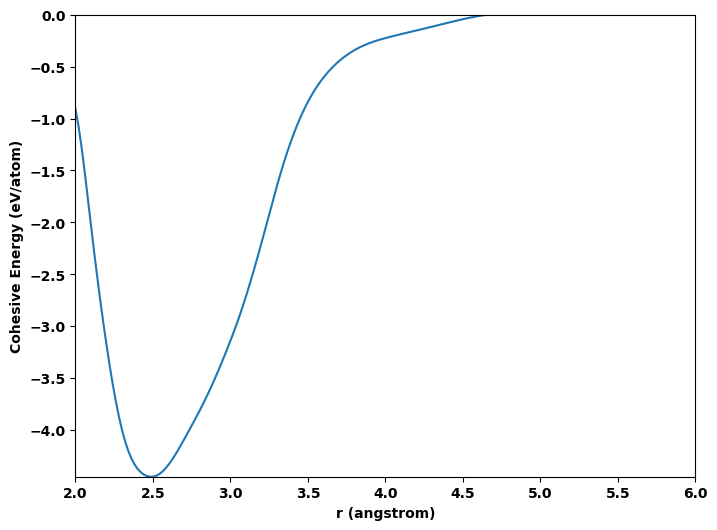

In [12]:
length_unit = 'angstrom'
energy_unit = 'eV'


Epot = uc.get_in_units(results_dict['Ecoh_values'], energy_unit)
r = uc.get_in_units(results_dict['r_values'], length_unit)


Emin = floor(Epot.min())
if Emin < -10: 
    Emin = -10

fig = plt.figure(figsize=(8,6))
plt.plot(r, Epot)
plt.xlim(r.min(), r.max())
plt.ylim(Epot.min(), 0.0)
plt.xlabel(f'r ({length_unit})')
plt.ylabel(f'Cohesive Energy ({energy_unit}/atom)')

plt.show()

In [13]:
for mincell in results_dict['min_cell']:
    print('Possible minimum near:')
    print('a =', uc.get_in_units(mincell.box.a, length_unit), length_unit)
    print('b =', uc.get_in_units(mincell.box.b, length_unit), length_unit)
    print('c =', uc.get_in_units(mincell.box.c, length_unit), length_unit)
    print()

Possible minimum near:
a = 3.510660803076929 angstrom
b = 3.510660803076929 angstrom
c = 3.510660803076929 angstrom

Possible minimum near:
a = 7.376651646951118 angstrom
b = 7.376651646951118 angstrom
c = 7.376651646951118 angstrom

